In this homework, the goal is to analyze a single-cell RNA-seq dataset derived from lung cancer patients. The data used in this homework is a subset of the data presented [here](https://pubmed.ncbi.nlm.nih.gov/34653364/).

Download the following data into the `data` directory
1. RU675_RU682.h5ad available at [link](https://drive.google.com/file/d/1jvuL2zYNpmdX4OH6-mKT9OZuEkOuz74-/view?usp=share_link)
2. RU675_filtered.tar.gz at [link](https://drive.google.com/file/d/11yQoiVrOcFuvtlJ06bNErlOTCsnnlWM5/view?usp=share_link). Untar this file after downloading.

The first part of the homework will use the data from one patient available at `data/RU675_filtered`. 
The batch correction section of the algorithm will make use of the data in the preprocessed anndata object `data/RU675_RU682.h5ad`. 

The homework is a series of empty code-cells which you will need to update to generate the necessary outputs. The expected outputs are shown in many instances. Note that the umaps and clusters you will  identify might be slightly different to the expected outputs due to random seeds used by `scanpy`.

The conda environment that you built for the class should work for the Homework too.

# Imports

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
# Plotting imports
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
%matplotlib inline

# Load data and QC - 5 points

Data is available to dowload at


Unlike the lecture, the data is not in the `h5` format, but exported as text

In [4]:
# The data can be loaded using the following
ad = sc.read_10x_mtx('data/RU675_filtered/')

In [5]:
# Compute QC metrics including the percent of mitochondrial fractions in the cells

# Set Mitochondrial genes
ad.var['mt'] = ad.var_names.str.startswith('MT-')

# Compute QC metrics
sc.pp.calculate_qc_metrics(ad, qc_vars=['mt'],
                           inplace=True, log1p=False)

In [6]:
# Print out the ad results
ad

AnnData object with n_obs × n_vars = 3666 × 20187
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

# Filter cells - 10 points

## Based on molecule counts 

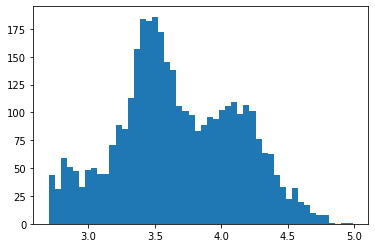

In [12]:
# Plot the histogram log10 molecule counts per cell.
# Hint: Use ad.obs['total_counts']
plt.hist(np.log10(ad.obs['total_counts']), 50);

In [26]:
# Remove cells with fewer than 1000 molecules and greater than 32000 molecules
use_cells = ad.obs_names[(ad.obs['total_counts'] < 32000) & \
    (ad.obs['total_counts'] > 1000) ]
ad = ad[use_cells, :]

In [27]:
# How many cells are retained after this filter?
ad

View of AnnData object with n_obs × n_vars = 3268 × 20187
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

3268 cells are retained after this filter

## Mitochondrial fraction 

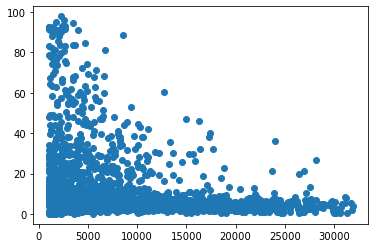

In [31]:
# Make a scatter plot with total_counts on the x-axis and pct_counts_mt on the y-axis
plt.scatter(ad.obs['total_counts'], ad.obs['pct_counts_mt'])

In [40]:
# How many cells do you find with a mitochondrial percentage > 20%
mt_abv_twenty = len(ad.obs_names[ad.obs['pct_counts_mt'] > 20])
print("Cells with a mitochondrial percentage > 20%: "+str(mt_abv_twenty))

Cells with a mitochondrial percentage > 20%: 343


In [44]:
# Remove cells with mitochondrial percentage > 20%
ad = ad[ad.obs['pct_counts_mt'] < 20, :]

## Additional information

The following methods take a more principled approach to identify cell-containing barcodes
* [EmptyDrops](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1662-y)
* [SoupX](https://academic.oup.com/gigascience/article/9/12/giaa151/6049831)
* [DecontX](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-1950-6)


# Preprocess the data - 10 points

In [45]:
# Save a copy
ad.layers['counts'] = ad.X.copy()

In [46]:
# Normalize the cells to correct for molecule count and perform log transformation
sc.pp.normalize_total(ad)
sc.pp.log1p(ad)

In [47]:
ad

AnnData object with n_obs × n_vars = 2925 × 20187
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'
    layers: 'counts'

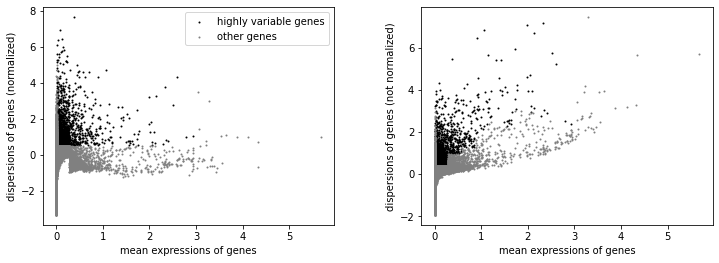

In [50]:
# Select highly variable genes and visaluze them
sc.pp.highly_variable_genes(ad)
sc.pl.highly_variable_genes(ad)

In [67]:
# How many genes were chosen to be highly variable?
len(ad.var_names[ad.var['highly_variable']])

3483

# Analysis - 45 points 

In [68]:
# Perform PCA on the normalized data [PCA + plot - 5points ]
sc.pp.pca(ad)

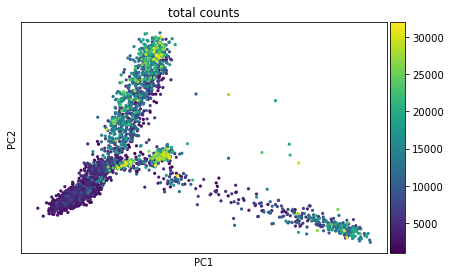

In [70]:
# Plot the first two PC components colored by total counts
sc.pl.scatter(ad, basis='pca', color='total_counts')

In [79]:
# Compute neighborhoods, clustering and umaps  -
# Computing and plotting: 5 points
sc.pp.neighbors(ad)
sc.tl.leiden(ad)
sc.tl.umap(ad)

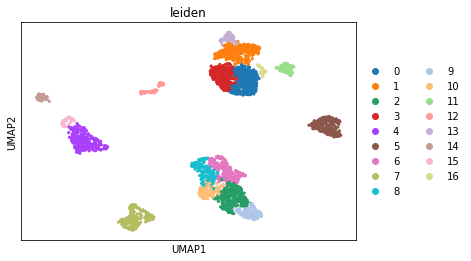

In [83]:
# Plot the umap colored leiden clusters
sc.pl.embedding(ad, basis='umap', color='leiden')

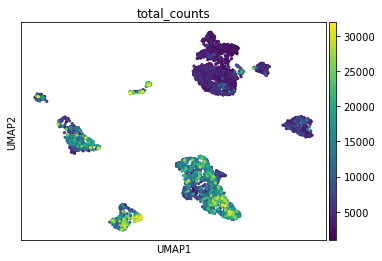

In [ ]:
# Plot the umap colored by total counts
sc.pl.embedding(ad, basis='umap', color='total_counts')

Here are the markers for different cell-types
* T-cells: CD3D
* B-cells: CD19
* Monocytes: FCER1G
* MAST cells: TPSB2
* Plasma cells: MZB1
* Epithelial: EPCAM
* Fibroblasts: CALD1
* Endothelial cells: SPARCL1


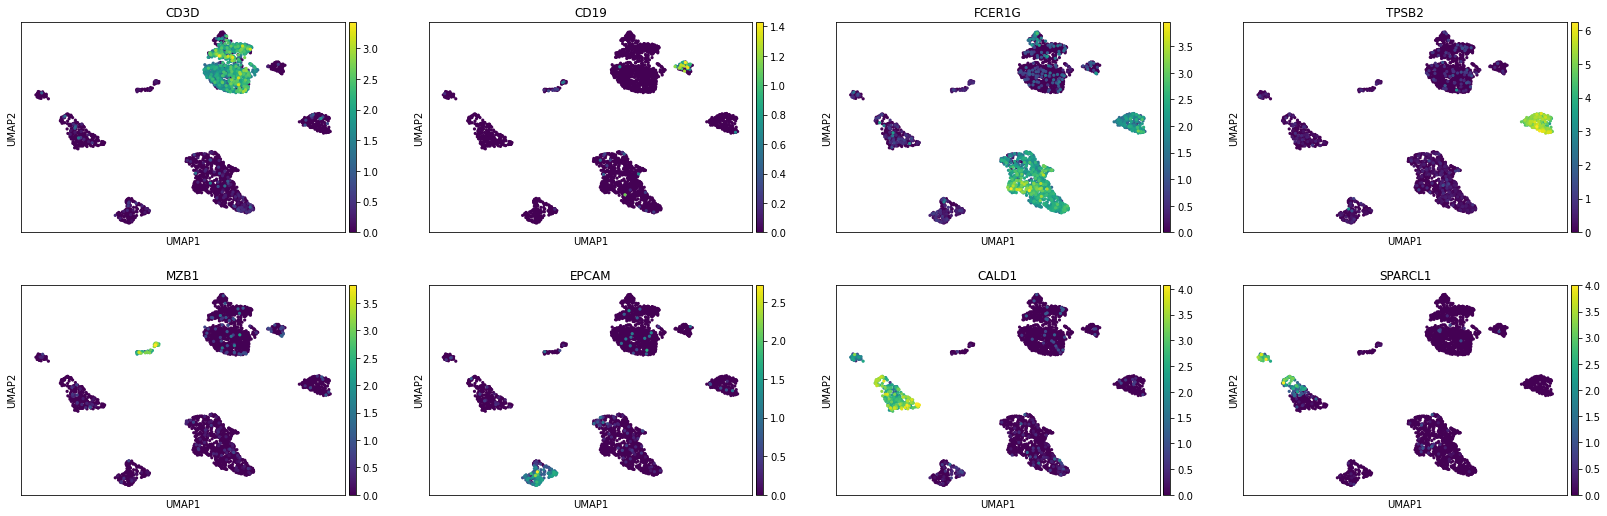

In [87]:
# Plot the expression of marker genes on umap - 5 points
marker_genes = ['CD3D', 'CD19', 'FCER1G', 'TPSB2', 'MZB1', 'EPCAM', 'CALD1', 'SPARCL1']

sc.pl.embedding(ad, basis='umap', color=marker_genes)

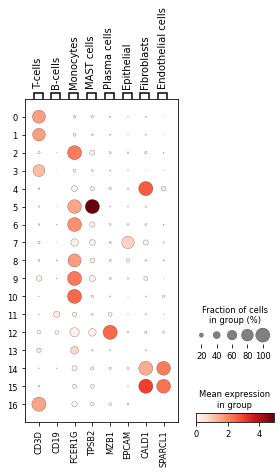

In [90]:
# Make a dotplot of these markers for each cluster - 5 points
marker_genes_dict = {
    'T-cells': 'CD3D',
    'B-cells': 'CD19',
    'Monocytes': 'FCER1G',
    'MAST cells': 'TPSB2',
    'Plasma cells': 'MZB1',
    'Epithelial': 'EPCAM',
    'Fibroblasts': 'CALD1',
    'Endothelial cells': 'SPARCL1'
}

sc.pl.dotplot(ad, marker_genes_dict, groupby='leiden');

In [94]:
# Use the visualization and dotplots to annotate each cluster with the cell-type -
# A pandas series can be used for generating the mapping
# Two example of how this can be done is mentioned in the cell
# 20 points for cell type annotation and plotting
ct_annotations = pd.Series(dtype=object)
ct_annotations['0'] = 'T-cells'
ct_annotations['1'] = 'T-cells'
ct_annotations['2'] = 'Monocytes'
ct_annotations['3'] = 'T-cells'
ct_annotations['4'] = 'Fibroblasts'
ct_annotations['5'] = 'MAST cells'
ct_annotations['6'] = 'Monocytes'
ct_annotations['7'] = 'Epithelial'
ct_annotations['8'] = 'Monocytes'
ct_annotations['9'] = 'Monocytes'
ct_annotations['10'] = 'Monocytes'
ct_annotations['11'] = 'B-cells'
ct_annotations['12'] = 'Plasma cells'
ct_annotations['13'] = 'T-cells'
ct_annotations['14'] = 'Endothelial cells'
ct_annotations['15'] = 'Fibroblasts'
ct_annotations['16'] = 'T-cells'

In [96]:
# Assign cell-types to cells. Note this code will work only if all clusters are annotated
ad.obs['celltype'] = ct_annotations[ad.obs['leiden']].values

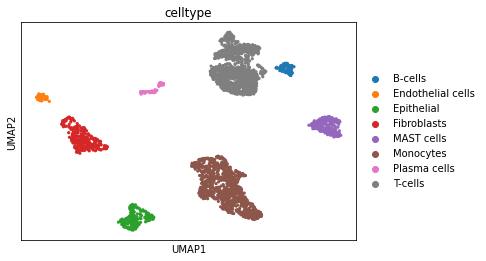

In [98]:
# Plot cell types on umap
sc.pl.embedding(ad, basis='umap', color='celltype')

## Extra credit (15 points) 
Write a procedure to automatically determine the cluster to cell-type annotations using marker gene expression. and cluster similarliy. 

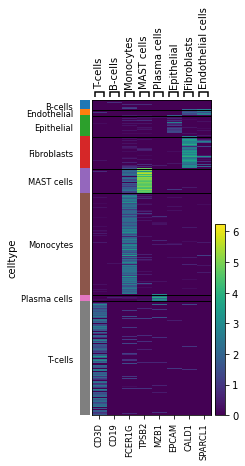

In [27]:
# Plot heatmap of marker genes per cell - 5 points



It is rather amazing that we can derive such heterogeneity from a single tumor biopsy !

## Additional information

There is a huge array of literature looking at different normalization techniques. Some interesting methods are 
* [SCtransform](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1)
* [SCNorm](https://www.nature.com/articles/nmeth.4263)
* [GLM-PCA](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1861-6)

There are a number of deep-learning autencoder methods that start with count matrices and provide representations for visualization, clustering and other downstream analyses
* [scVI](https://www.google.com/search?client=safari&rls=en&q=scvi+single+cell&ie=UTF-8&oe=UTF-8)
* [DCA](https://www.nature.com/articles/s41467-018-07931-2)
* [Saucie](https://www.nature.com/articles/s41592-019-0576-7)


# Analysis of a subset - 20 points

Often times with single-cell data analysis, we will need to re-analyze a compartment to understand the structure better. In this section, the goal is to zoom into the epithelial compartment. 

In [28]:
# Create a new anndata object called "sub_ad" with only T-cells
sub_ad = ad[ad.obs['celltype'] == 'T-cells', :]
sub_ad

View of AnnData object with n_obs × n_vars = 1059 × 20187
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'celltype'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'leiden', 'umap', 'leiden_colors', 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

<b> Questions - 5 points</b>
* Should the data be normalized again ?
* Why or why not ? 

In [29]:
# Recompute the highly variable genes for this subset of cells
# Question: Why is this necessary


Trying to set attribute `._uns` of view, copying.


In [30]:
# Perform PCA and compute clusters and umap


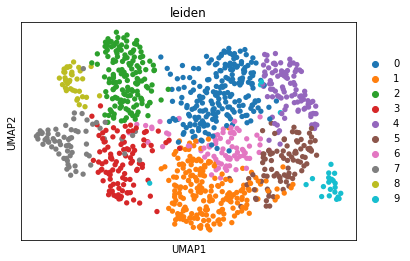

In [32]:
# Identify differentially expressed genes per cluster


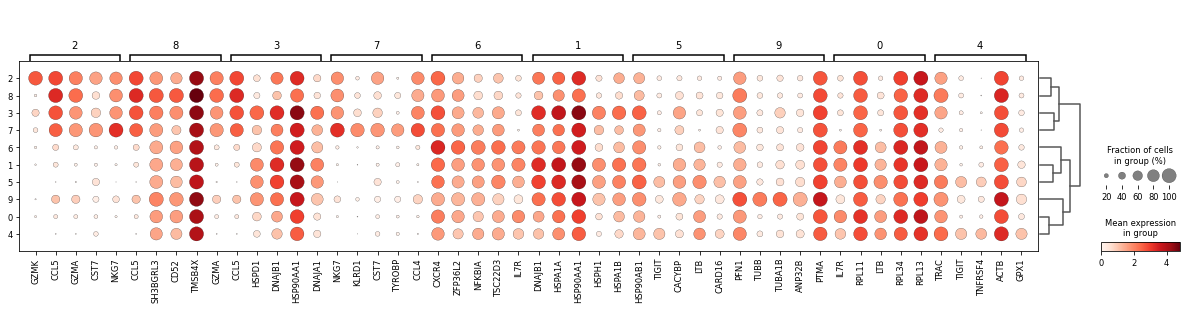

In [33]:
# Plot the top 5 genes per cluster as a dotplot
sc.tl.dendrogram(sub_ad, 'leiden') # This command is necessary since the clusters were re-computed


# Batch correction (Extra credit) - 10 points

In this section, the goal is to batch correct data from two normal samples. 

In [ ]:
# Load the anndata
norm_ad = sc.read('data/RU675_RU682.h5ad')

In [35]:
# The preprocessing and analysis steps are already done in this anndata object
norm_ad

AnnData object with n_obs × n_vars = 6620 × 17287
    obs: 'sample', 'batch', 'celltype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'leiden', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

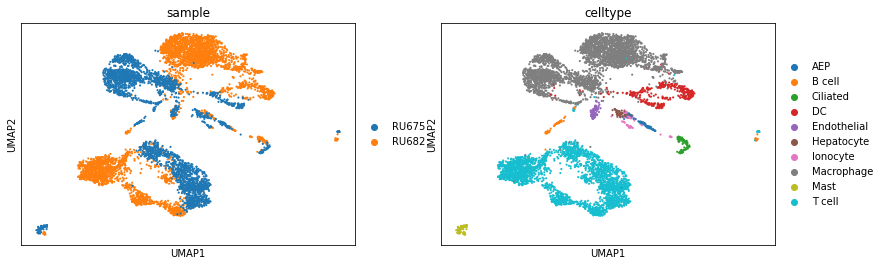

In [36]:
# Visualize the sample and cell type on the already computed umaps


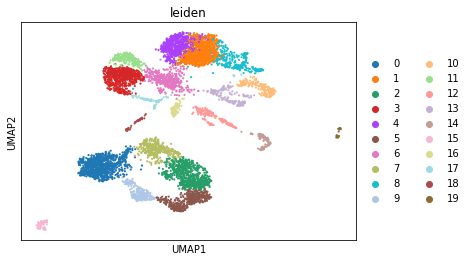

In [37]:
# Visualize the clusters


In [38]:
# Save the pre-batch correction as leiden_pre_correction
norm_ad.obs['leiden_pre_correction'] = norm_ad.obs['leiden']

In [ ]:
# Apply batch correction using Harmony and re-computed UMAPs and clusters


2021-11-20 22:46:16,750 - harmonypy - INFO - Iteration 1 of 10
2021-11-20 22:46:18,058 - harmonypy - INFO - Iteration 2 of 10
2021-11-20 22:46:19,635 - harmonypy - INFO - Iteration 3 of 10
2021-11-20 22:46:21,161 - harmonypy - INFO - Iteration 4 of 10
2021-11-20 22:46:22,556 - harmonypy - INFO - Iteration 5 of 10
2021-11-20 22:46:23,981 - harmonypy - INFO - Converged after 5 iterations


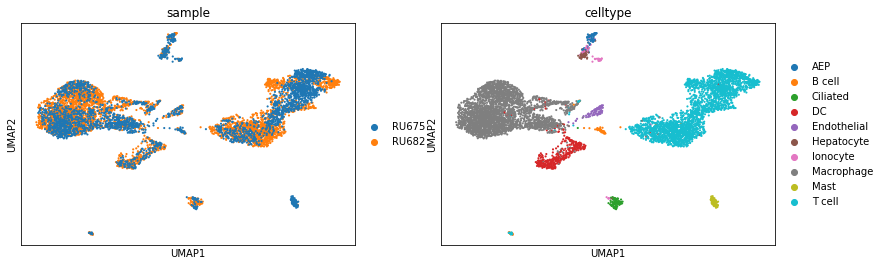

In [40]:
# Visualize the batch corrected-clusters and celltypes on batch-corrected umaps


<b>Question</b>: What are you observations? 

## Extra credit - 10 points

In [ ]:
# Goal - identify how the pre-batch correction clusters are reassigned after batch correction
# Compute a matrix where each row is the batch corrected cluster and each column is a pre-corrected cluster
# Each entry of the matrix should represent the number of cells in
# each (pre-batch correction and post-correction) clusters


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0,825,0,0,70,0,0,0,0,0,0,0,0,0,0
1,841,0,1,9,0,17,7,0,0,0,0,0,0,0,0
2,0,9,374,0,338,0,0,0,0,2,0,0,0,0,0
3,545,0,0,6,0,1,70,0,0,0,0,0,0,0,0
4,10,0,0,549,0,17,0,0,0,0,0,0,0,0,0
5,0,0,467,0,0,0,0,0,0,0,0,0,0,0,0
6,6,0,0,3,0,395,0,2,1,0,0,0,0,0,0
7,0,329,0,0,20,1,0,0,0,0,0,0,0,0,0
8,6,0,0,0,0,3,277,0,0,0,0,0,0,0,0
9,0,0,49,0,42,0,0,0,0,127,0,0,0,0,0


<AxesSubplot:>

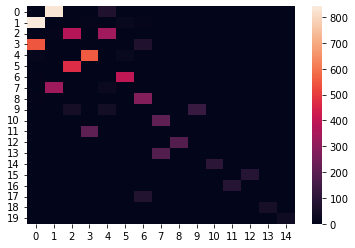

In [ ]:
# Plot the count matrix as a heatmap


In [ ]:
# Normalize such that each row sums to 1


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.000000,0.921788,0.000000,0.000000,0.078212,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
1,0.961143,0.000000,0.001143,0.010286,0.000000,0.019429,0.008000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
2,0.000000,0.012448,0.517289,0.000000,0.467497,0.000000,0.000000,0.000000,0.000000,0.002766,0.0,0.0,0.0,0.000000,0.0
3,0.876206,0.000000,0.000000,0.009646,0.000000,0.001608,0.112540,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
4,0.017361,0.000000,0.000000,0.953125,0.000000,0.029514,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
5,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
6,0.014742,0.000000,0.000000,0.007371,0.000000,0.970516,0.000000,0.004914,0.002457,0.000000,0.0,0.0,0.0,0.000000,0.0
7,0.000000,0.940000,0.000000,0.000000,0.057143,0.002857,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
8,0.020979,0.000000,0.000000,0.000000,0.000000,0.010490,0.968531,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
9,0.000000,0.000000,0.224771,0.000000,0.192661,0.000000,0.000000,0.000000,0.000000,0.582569,0.0,0.0,0.0,0.000000,0.0


<AxesSubplot:>

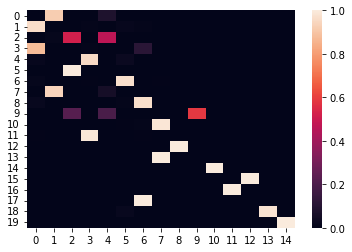

In [ ]:
# Plot the count matrix as a heatmap
